In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from pyspark import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, Bucketizer, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.stat import Statistics
from pyspark.mllib.evaluation import MulticlassMetrics

from elephas.ml_model import ElephasEstimator
from elephas import optimizers as elephas_optimizers

#### Exploratory data analysis (EDA)

In [3]:
# Carrega dataset do desafio (basta descompactar todos na mesma pasta)
#display(dbutils.fs.ls("dbfs:/FileStore/tables/"))
df_desafio = spark.read.format("csv").options(header='true').load("/FileStore/tables/*.csv")

In [4]:
# Elimina na's e duplicados do df
df_desafio_v2 = df_desafio.dropna(how='any').dropDuplicates()

# Ajusta tipo de colunas
df_desafio_v2 = df_desafio_v2.selectExpr(
  'cast(time as timestamp) time',
  'ca',
  'unit',
  'scp',
  'station',
  'linename',
  'division',
  'desc',
  'cast(entries as int) entries',
  'cast(exits as int) exits'
)

# Features para visão temporal
df_desafio_v2 = df_desafio_v2.withColumn(
  "dt_year",
  year(col("time"))
).withColumn(
  "dt_month",
  month(col("time"))
).withColumn(
  "dt_day",
  dayofmonth(col("time"))
).withColumn(
  "dt_dayofy",
  dayofyear(col("time"))  
).withColumn(
  "dt_hour",
  hour(col("time"))
).withColumn(
  "dt_min",
  minute(col("time"))
).withColumn(
  "dt_week_no",
  weekofyear(col("time"))
).withColumn(
  "dt_int",
  unix_timestamp(col("time"))
).withColumn(
  "dt_month_year",
  date_format(col("time"), "Y-MM")
)

In [5]:
# Intervalos para buckets
splits = [-30000000, -20000000, -10000000, 0.0, 10000000, 20000000, 30000000]

# ===> Bucket: 'entries'
# dataFrame = df_desafio_v2.select(col('entries'))
# bucketizer = Bucketizer(splits=splits, inputCol="entries", outputCol="bucketedFeatures")
# bucketedData_entries = bucketizer.transform(dataFrame)
# sorted(bucketedData_entries.groupBy("bucketedFeatures").count().collect())
# [Row(bucketedFeatures=0.0, count=15721),
#  Row(bucketedFeatures=1.0, count=4028),
#  Row(bucketedFeatures=2.0, count=496),
#  Row(bucketedFeatures=4.0, count=71457425), ==> Begin
#  Row(bucketedFeatures=5.0, count=5052549),  <== End
#  Row(bucketedFeatures=6.0, count=278162),
#  Row(bucketedFeatures=7.0, count=2237294)]

# ===> Bucket: 'exits'
# dataFrame = df_desafio_v2.select(col('exits'))
# bucketizer = Bucketizer(splits=splits, inputCol="exits", outputCol="bucketedFeatures")
# bucketedData_exits = bucketizer.transform(dataFrame)
# sorted(bucketedData_exits.groupBy("bucketedFeatures").count().collect())
# [Row(bucketedFeatures=0.0, count=30576),
#  Row(bucketedFeatures=2.0, count=576),
#  Row(bucketedFeatures=3.0, count=1),
#  Row(bucketedFeatures=4.0, count=73751241), ==> Begin
#  Row(bucketedFeatures=5.0, count=3698911),  <== End
#  Row(bucketedFeatures=6.0, count=413740),
#  Row(bucketedFeatures=7.0, count=1150630)]

# Parâmetros para filtros de outliers
outlier_begin = 0
outlier_end = 20000000

df_desafio_v2 = df_desafio_v2.where((col('entries')>=outlier_begin) & (col('entries')<=outlier_end) & (col('exits')>=outlier_begin) & (col('exits')<=outlier_end))

In [6]:
# Check: 79.609.191 / 79.130.015 / 79.045.675 / 75.923.980
count_desafio = df_desafio.count()
count_desafio_na = df_desafio.dropna(how='any').count()
count_desafio_final = df_desafio.dropna(how='any').dropDuplicates().count()
count_desafio_outliers = df_desafio_v2.count()

df_amostras = sc.parallelize([
  ('antes',count_desafio,0,0,0,0),
  ('depois',0,count_desafio_final,count_desafio-count_desafio_na,count_desafio_na-count_desafio_final,count_desafio_final-count_desafio_outliers)
]).toDF(['AMOSTRAS','TOTAL','UNICO','NA','DUPLICADO','OUTLIERS'])

display(df_amostras)

In [7]:
df_amostras_v2 = sc.parallelize([
  ('',count_desafio-count_desafio_na,count_desafio_na-count_desafio_final,count_desafio_final-count_desafio_outliers)
]).toDF(['AMOSTRAS','NA','DUPLICADO','OUTLIERS'])

display(df_amostras_v2)

In [8]:
# Método para variáveis categóricas (dummys) ~14.59 minutes
lista_idx = ['ca', 'unit', 'scp', 'station', 'linename', 'division', 'desc']
indexers = [StringIndexer(inputCol=column,outputCol=column+"_idx").fit(df_desafio_v2) for column in lista_idx]
pipeline = Pipeline(stages=indexers)
df_desafio_v2 = pipeline.fit(df_desafio_v2).transform(df_desafio_v2)
#display(df_desafio_v2)

In [9]:
df_desafio_v2.write.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio_num.write.parquet("/FileStore/tables/df_desafio_ml.parquet")

In [10]:
df_desafio = spark.read.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio.registerTempTable("df_desafio")

df_desafio_graf = df_desafio.groupBy(
  'dt_month_year',
  'dt_year',
  'dt_month',
  'dt_day',
  'dt_hour'
).agg(
  sum('entries'),
  sum('exits')
).orderBy(
  "dt_month_year"
)

In [11]:
# Descritiva das variáveis de interesse
var_interesse = 'entries' #exits
df = sqlContext.sql("select 'entries' as var, min(entries) as minimo,percentile_approx(entries, 0.5) as mediana, int(avg(entries)) as media, max(entries) as maximo from df_desafio union select 'exits' as var, min(exits) as minimo,percentile_approx(exits, 0.5) as mediana, int(avg(exits)) as media, max(exits) as maximo from df_desafio")
df.show(10)

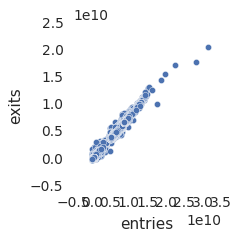

In [12]:
# Relação direita entre variáveis
var_interesse = 'exits'
colunas = ['dt_year', 'dt_month', 'dt_day', 'dt_hour','entries', 'exits']

sns.pairplot(df,x_vars='entries',y_vars=var_interesse)
display()

In [13]:
# Base para Regressão Simples
df_desafio_rl = df_desafio.groupBy(  
  'dt_year',
  'dt_month',
  'ca_idx',
  'unit_idx',
  'scp_idx',
  'station_idx',
  'linename_idx',
  'division_idx',
  'desc_idx'
).agg(
  sum('entries'),
  sum('exits')
)
#df_desafio_rl.count()
df_rl = df_desafio_rl.toPandas()
df_rl.columns = ['dt_year', 'dt_month', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx','linename_idx', 'division_idx', 'desc_idx', 'entries','exits']

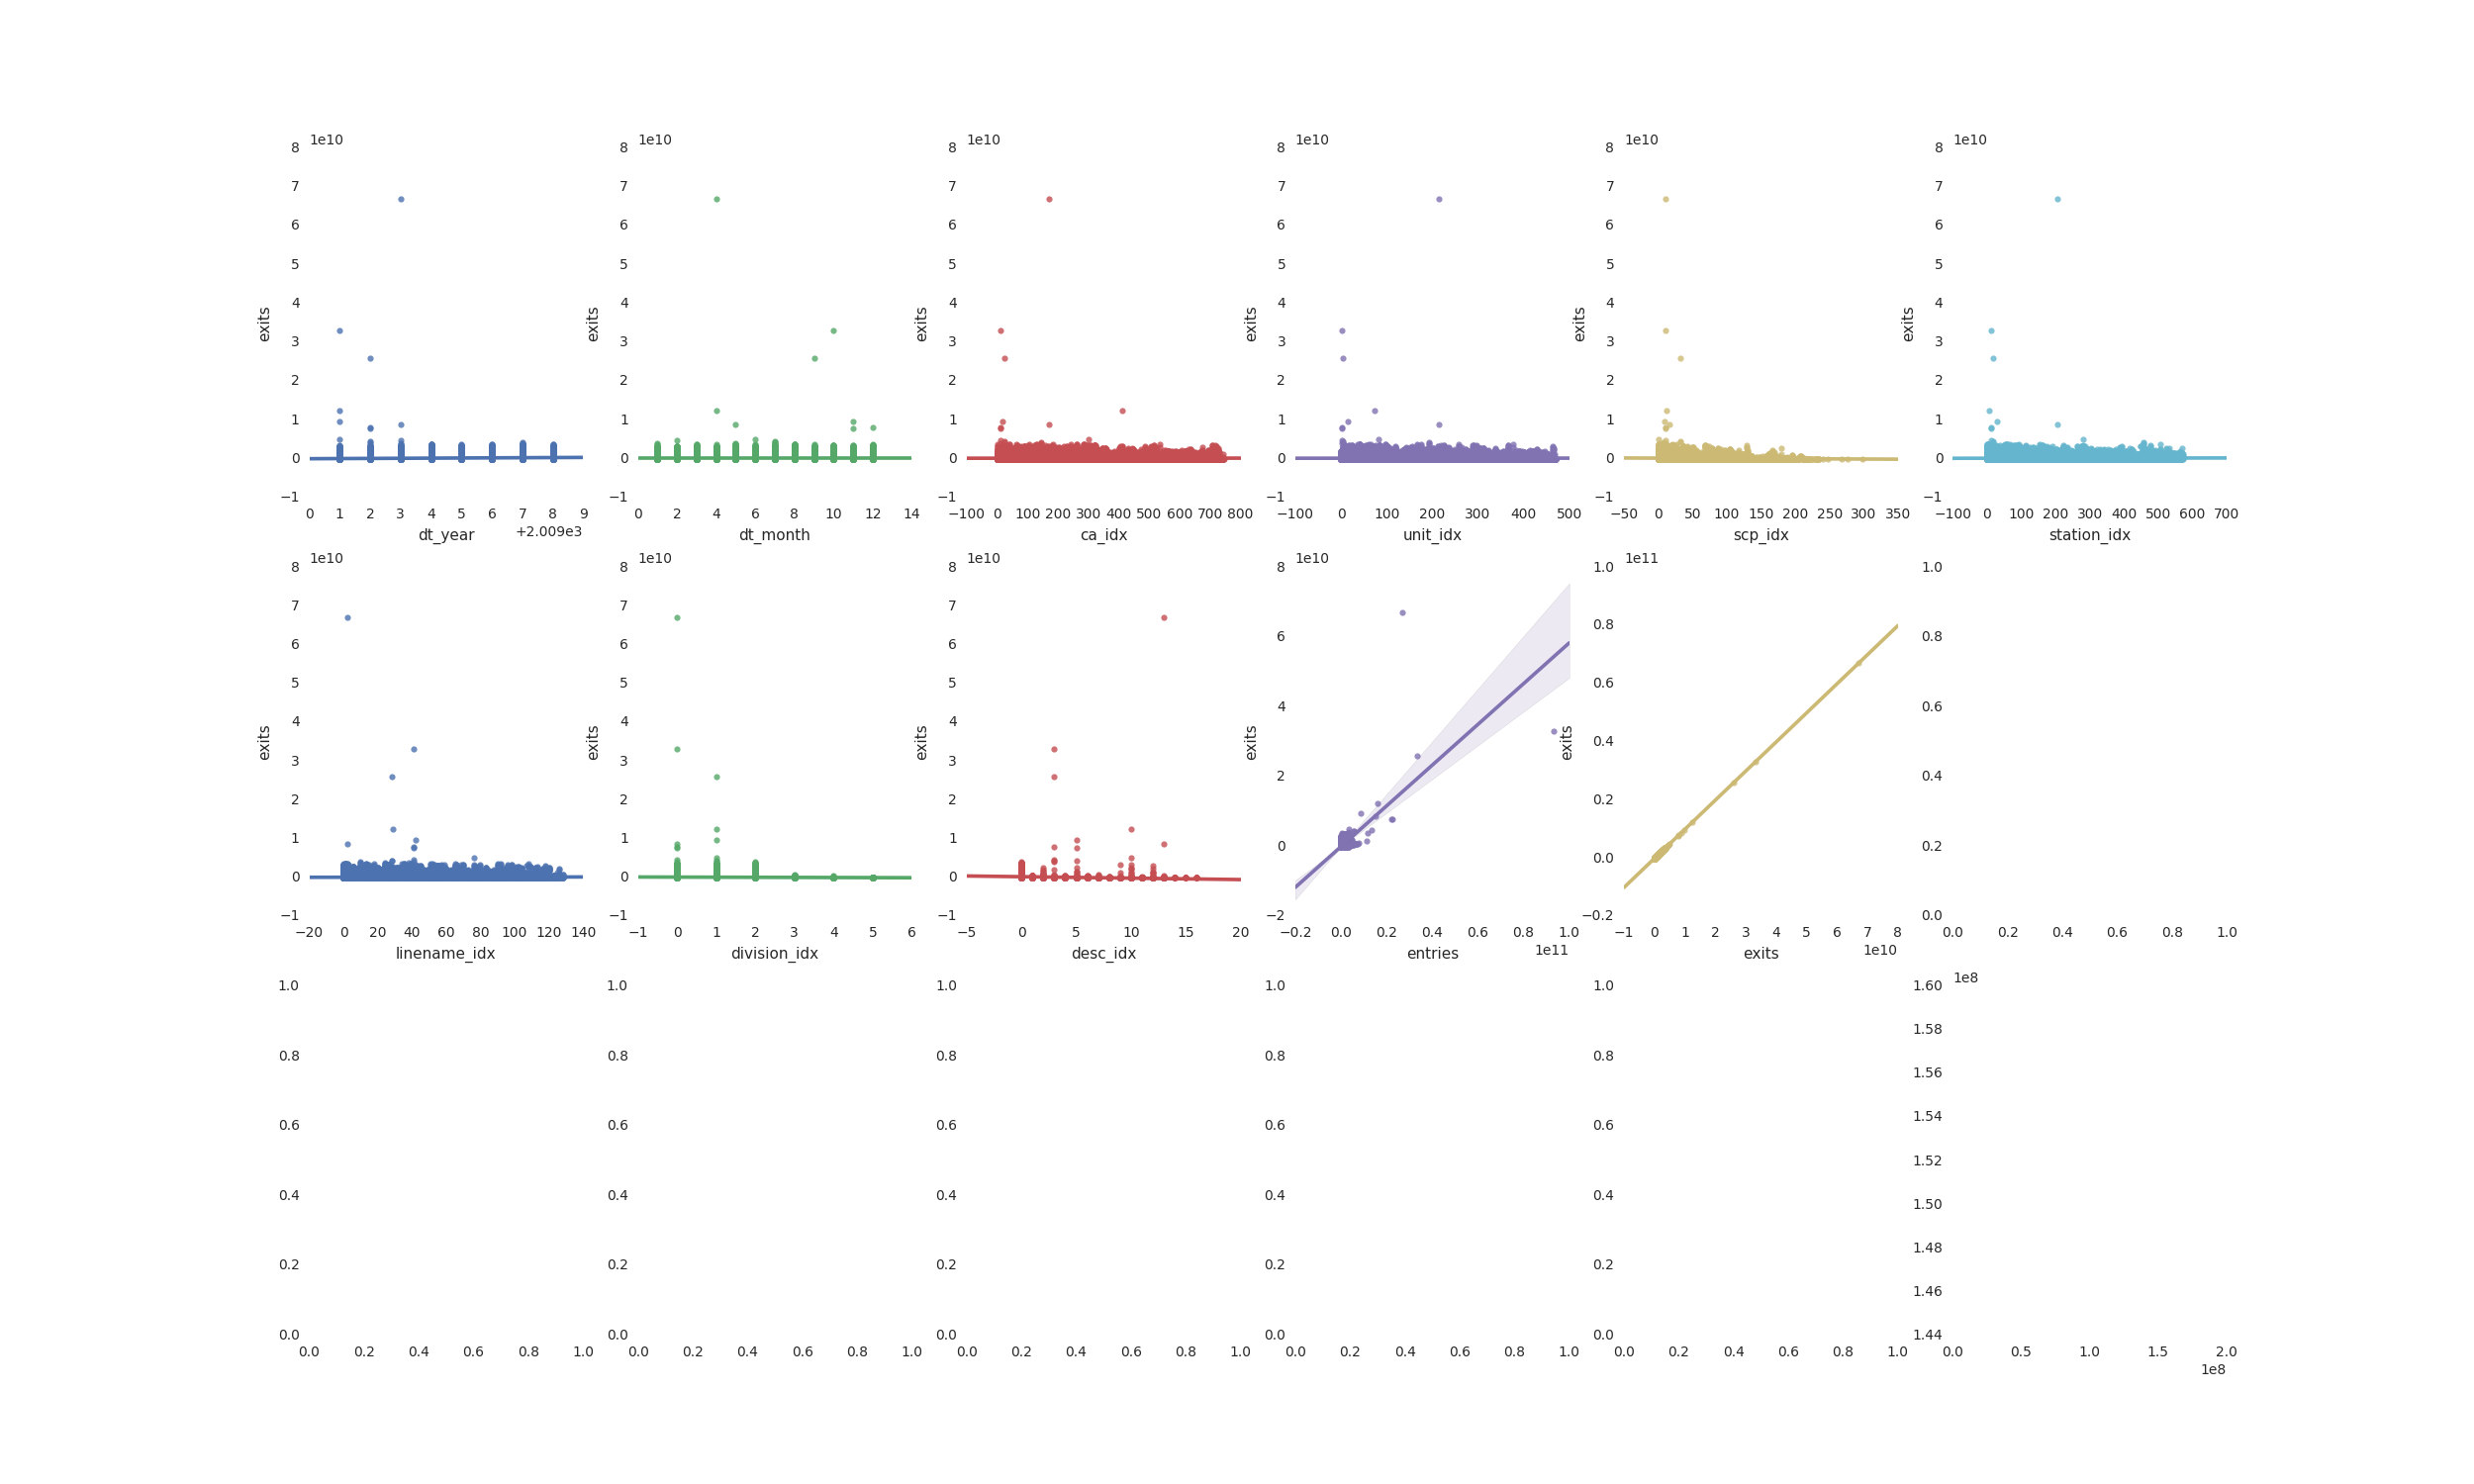

In [14]:
# Regressão Simples ~30min +/-
var_interesse = 'exits'
colunas = df_rl.columns

fig, ax = plt.subplots(3, 6, figsize = (25, 15))

for i, ax in enumerate(fig.axes):
    if i < len(df_rl.columns):
        sns.regplot(x=colunas[i],y=var_interesse, data=df_rl[:100000], ax=ax)        
display()

In [15]:
# Gráfico de barras
display(df_desafio.groupBy(  
  'dt_month_year'  
).agg(
  sum('entries'),
  sum('exits')
).orderBy('dt_month_year')
)

dt_month_year,sum(entries),sum(exits)
2010-04,687568607473,539358319974
2010-05,2050265160180,1638986347322
2010-06,2525934069287,2032037009670
2010-07,2614283219055,2099631960580
2010-08,2583276375877,2084031693122
2010-09,2583009694320,2080965154650
2010-10,2821675935471,2198469988715
2010-11,2557657419840,2045039960490
2010-12,2212557413783,1783468307611
2011-01,2761664970744,2228312183219


In [16]:
# Base para Boxplot
df_desafio_box = df_desafio.filter(col('dt_year') == '2016').groupBy(
  'dt_month_year',
  'dt_year',
  'dt_month',
  'dt_day',
  'dt_hour'
).agg(
  sum('entries'),
  sum('exits')
).orderBy('dt_month_year')
#df_desafio_rl.count()
df_box = df_desafio_box.toPandas()
df_box.columns = ['dt_month_year', 'dt_year', 'dt_month', 'dt_day', 'dt_hour', 'entries', 'exits']

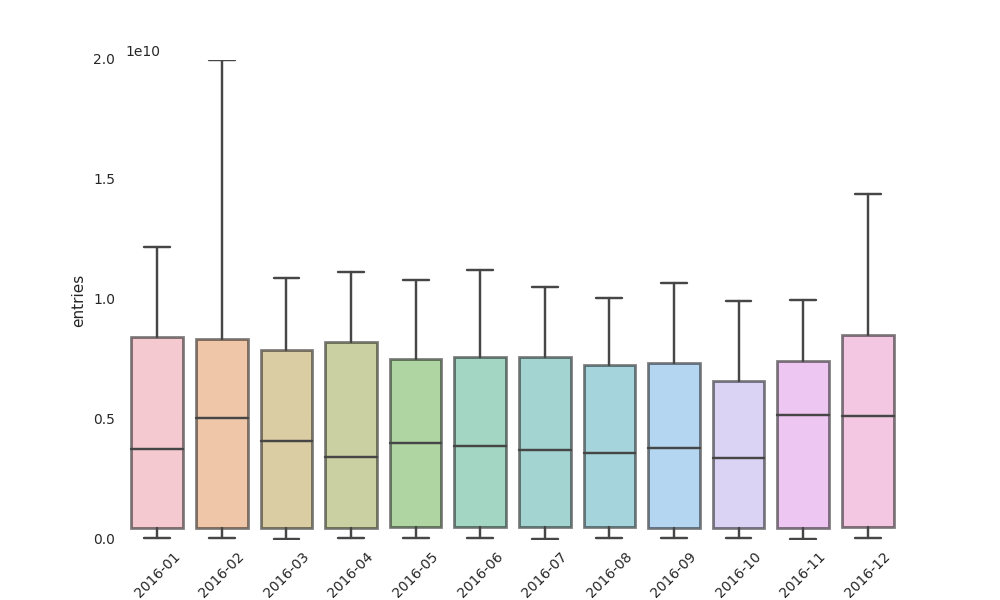

In [17]:
# Gráfico para Boxplot
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='dt_month_year', y='entries', data=df_box)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.ylim(0, 20000000000)
plt.xticks(rotation=45)
display()

#### Carga de Parquet para modelos

In [19]:
# Carrega Parquet
df_desafio_pqt = spark.read.parquet("/FileStore/tables/df_desafio.parquet")
df_desafio_num = df_desafio_pqt.select(
  'entries','exits','dt_year','dt_month','dt_day','dt_dayofy',
  'dt_hour','dt_min','dt_week_no','dt_int','ca_idx','unit_idx',
  'scp_idx','station_idx','linename_idx','division_idx','desc_idx'
)

#### Correlação entre features

In [21]:
# Gera matriz de correlação
col_names = df_desafio_num.columns
features = df_desafio_num.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
spark.createDataFrame(corr_df).write.parquet("/FileStore/tables/corr_df.parquet")

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 

 Py4JJavaError : An error occurred while calling o2999.parquet.
: org.apache.spark.sql.AnalysisException: path dbfs:/FileStore/tables/corr_df.parquet already exists.;
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:148)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:110)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:128)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:143)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$5.apply(SparkPlan.scala:183)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:114)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:114)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:690)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:690)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withCustomExecutionEnv$1.apply(SQLExecution.scala:91)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:227)
	at org.apache.spark.sql.execution.SQLExecution$.withCustomExecutionEnv(SQLExecution.scala:86)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:157)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:690)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:290)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:284)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:232)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:579)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)


During handling of the above exception, another exception occurred:

 AnalysisException Traceback (most recent call last)
 <command-1146625930861805> in <module> 
 4 corr_df = pd . DataFrame ( corr_mat ) 
 5 corr_df . index , corr_df . columns = col_names , col_names
 ----> 6 spark . createDataFrame ( corr_df ) . write . parquet ( "/FileStore/tables/corr_df.parquet" ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in parquet (self, path, mode, partitionBy, compression) 
 839 self . 

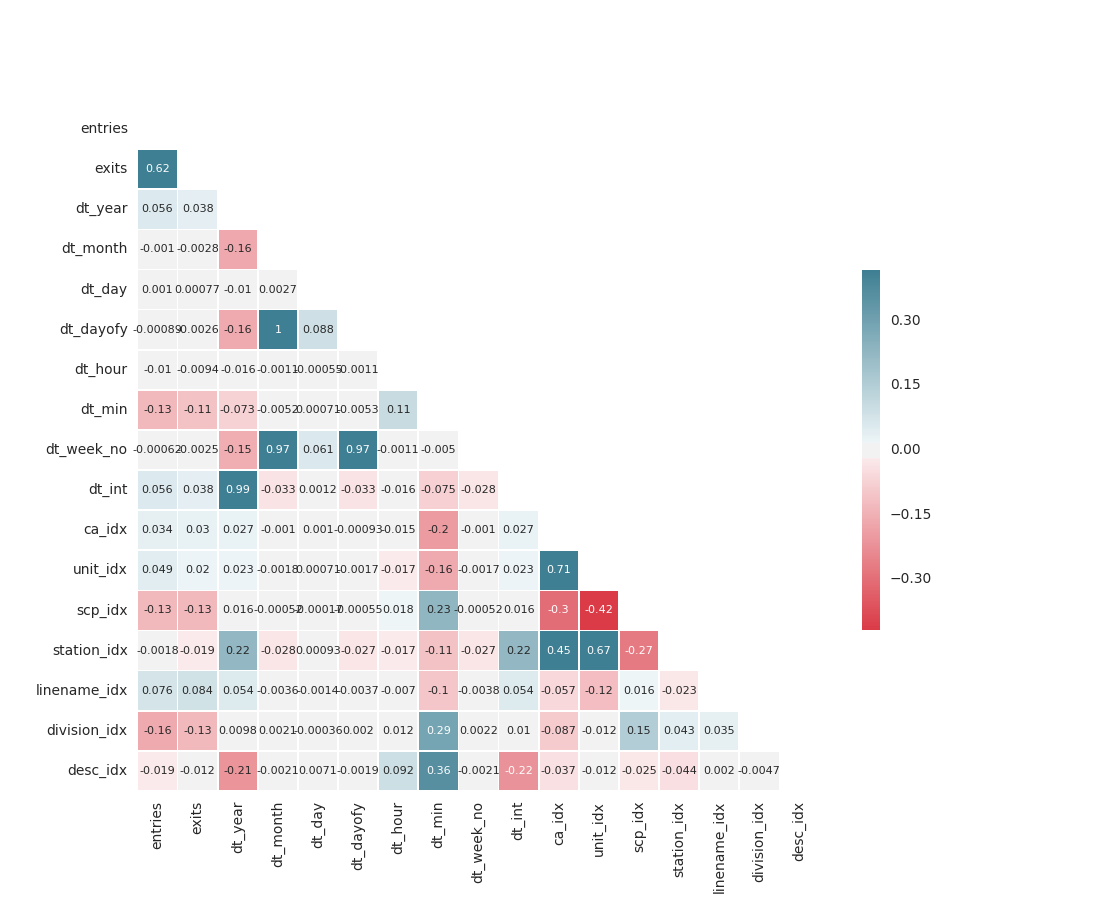

In [22]:
# Matriz de correlação - Gráfio
#corr_pq = spark.read.parquet("/FileStore/tables/corr_df.parquet")
corr = corr_df

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

display()

#### Modelo de Machine Learning - Regressão Linear

In [24]:
# Vetorização de features
colunas = ['exits', 'dt_year', 'dt_month', 'dt_day', 'dt_dayofy', 'dt_hour', 'dt_min', 'dt_week_no', 'dt_int', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx', 'linename_idx', 'division_idx', 'desc_idx']
vectorAssembler = VectorAssembler(inputCols = colunas, outputCol = 'features')
vdf_desafio_num = vectorAssembler.transform(df_desafio_num)
vdf_desafio_num.take(1)

# Seleciona features de interesse
vdf_desafio_num = vdf_desafio_num.select(['features', 'entries'])
vdf_desafio_num.show(3)

# Split para dados de treino/teste
splits = vdf_desafio_num.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

+--------------------+-------+
 features|entries|
+--------------------+-------+
[2380798.0,2010.0...|2827995|
[834908.0,2010.0,...| 704052|
[2562997.0,2010.0...|2130785|
+--------------------+-------+
only showing top 3 rows

In [25]:
# Treinando o modelo com dados de treino para predizer os dados de teste
lr = LinearRegression(featuresCol = 'features', labelCol='entries', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-189668614051522> in <module> 
 4 
 5 #Salva modelo treinado 
 ----> 6 lr_model . save ( "/FileStore/tables/lr_model" ) 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 242 def save ( self , path ) : 
 243 """Save this ML instance to the given path, a shortcut of 'write().save(path)'.""" 
 --> 244 self . write ( ) . save ( path ) 
 245 
 246 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 181 if not isinstance ( path , basestring ) : 
 182 raise TypeError ( "path should be a basestring, got type %s" % type ( path ) ) 
 --> 183 self . _jwrite . save ( path ) 
 184 
 185 def overwrite ( self ) : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 61 def deco ( * a , ** kw ) : 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 
 65 s = e . java_exception . toString ( ) 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 
 330 raise Py4JError(

 Py4JJavaError : An error occurred while calling o6668.save.
: java.io.IOException: Path /FileStore/tables/lr_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:702)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:179)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)

In [26]:
#Salva modelo treinado
lr_model.save("/FileStore/tables/lr_model_exits")

In [27]:
# Predição dos dados de teste vs Real
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","entries","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="entries",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

# Resultado RMSE do modelo de teste
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

+------------------+-------+--------------------+
 prediction|entries| features|
+------------------+-------+--------------------+
1742204.8904536366| 494146|(16,[0,1,2,3,4,7,...|
1796703.8671003878| 690051|(16,[0,1,2,3,4,7,...|
1810595.4433376193| 817519|(16,[0,1,2,3,4,7,...|
 1820536.40949893| 839845|(16,[0,1,2,3,4,7,...|
 1845445.308393851| 922695|(16,[0,1,2,3,4,7,...|
+------------------+-------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.398379
Root Mean Squared Error (RMSE) on test data = 2.79633e+06

In [28]:
# Histograma para residuals
display(trainingSummary.residuals)

numIterations: 11
objectiveHistory: [0.49999999999999994, 0.4358322872693952, 0.33387562114036246, 0.3094080145229663, 0.30312278591010033, 0.30167083969757397, 0.30119670110615065, 0.300980857377604, 0.30092164563465645, 0.3008707574863918, 0.30084772615985284]

#### Modelo de Deep Learning - Elephas

In [30]:
# Etapa 01 - Transformações: VectorAssembler

# Variáveis para modelo
features = ['entries', 'exits', 'dt_year', 'dt_month', 'dt_day', 'dt_dayofy', 'dt_hour', 'dt_min', 'dt_week_no', 'dt_int', 'ca_idx', 'unit_idx', 'scp_idx', 'station_idx', 'linename_idx', 'division_idx', 'desc_idx']
var_predict = 'entries'
features.remove(var_predict)

# Vetorização de features
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_desafio = vectorAssembler.transform(df_desafio_num)

# Seleciona features + interesse (y)
df_desafio = df_desafio.select(['features', var_predict])

# Divisão de dados para treino e teste
splits = df_desafio.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [31]:
# Etapa 02 - Transformações: StringIndexer & StandardScaler
string_indexer = StringIndexer(inputCol=var_predict, outputCol="index_category")
fitted_indexer = string_indexer.fit(train_df)
indexed_df = fitted_indexer.transform(train_df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
fitted_scaler = scaler.fit(indexed_df)
scaled_df = fitted_scaler.transform(indexed_df)

In [32]:
# Keras Deep Learning model
nb_classes = train_df.select(var_predict).distinct().count()
input_dim = len(train_df.select("features").first()[0])

model = Sequential()
model.add(Dense(512, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [33]:
# Define elephas optimizer (which tells the model how to aggregate updates on the Spark master)
Adadelta = elephas_optimizers.Adadelta()

# Initialize SparkML Estimator and set all relevant properties
estimator = ElephasEstimator()
estimator.setFeaturesCol("scaled_features")             # These two come directly from pyspark,
estimator.setLabelCol("index_category")                 # hence the camel case. Sorry :)
estimator.set_keras_model_config(model.to_yaml())       # Provide serialized Keras model
estimator.set_optimizer_config(Adadelta.get_config())   # Provide serialized Elephas optimizer
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(2)  # We just use one worker here. Feel free to adapt it.
estimator.set_epochs(20) 
estimator.set_batch_size(128)
estimator.set_verbosity(1)
estimator.set_validation_split(0.15)
estimator.set_loss('squaredError')

In [34]:
# SparkML Pipelines
pipeline = Pipeline(stages=[string_indexer, scaler, estimator])

In [35]:
# Bug encontrado no fit, tentando resolver: https://github.com/maxpumperla/elephas/issues/122
# Fitting and evaluating the pipeline
fitted_pipeline = pipeline.fit(train_df) # Fit model to data

In [36]:
prediction = fitted_pipeline.transform(train_df) # Evaluate on train data.
# prediction = fitted_pipeline.transform(test_df) # <-- The same code evaluates test data.
pnl = prediction.select("index_category", "prediction")

prediction_and_label = pnl.map(lambda row: (row.index_category, row.prediction))
metrics = MulticlassMetrics(prediction_and_label)
print(metrics.precision())